Примеры:
* https://github.com/bigartm/bigartm-book/blob/master/ARTM_example_RU.ipynb
* https://github.com/bigartm/bigartm-book/blob/master/ARTM_tutorial_RU.ipynb
* http://localhost:8888/notebooks/examples/2/%D0%94%D0%B5%D0%BC%D0%BE%D0%BD%D1%81%D1%82%D1%80%D0%B0%D1%86%D0%B8%D1%8F-BigARTM-0.8.0.ipynb

In [20]:
%matplotlib inline
import glob
import os
import matplotlib.pyplot as plt

import artm

# Адрес, по которому находятся данные
BATCH_ADRESS = 'batches_news'

# Вывод версии BigARTM
print(artm.version())

0.10.0


In [21]:
# Установка адреса, по которому находятся данные
batch_vectorizer = artm.BatchVectorizer(
    data_path=BATCH_ADRESS, data_format='batches'
)

In [22]:
# Пересоздание словаря для модели и сохранение его в файл

# Устанавливается название словаря для модели
dictionary_address = BATCH_ADRESS + '/dictionary.dict'

# Инициализация словоря для модели
dictionary = artm.Dictionary()

# Удаление словаря, оставшегося после предыдущих запусков
if os.path.isfile(dictionary_address):
    os.remove(dictionary_address)
    
# Сохранение словаря в файл
dictionary.gather(data_path=batch_vectorizer.data_path)
dictionary.save(dictionary_path=dictionary_address)

# Загрузка словаря из файла
dictionary.load(dictionary_path=dictionary_address)
print("Количество слов в словаре:", dictionary.__dict__['_master'].get_info().dictionary[0].num_entries)


# Фильтрация

# Убираются слова, которые попадаются меньше чем в n процентов документов
dictionary.filter(min_df_rate=0.01)
print(
    "Количество слов в словаре после фильтрации по min_df_rate:", 
    dictionary.__dict__['_master'].get_info().dictionary[0].num_entries
)

# Убираются слова, которые попадаются больше чем в n процентов документов
dictionary.filter(max_df_rate=0.5)
print(
    "Количество слов в словаре после фильтрации по max_df_rate:", 
    dictionary.__dict__['_master'].get_info().dictionary[0].num_entries
)

# Убираются редкие слова по всей коллекции
# Слово встречается во всей коллекции больше чем n раз
dictionary.filter(min_tf=10)
print(
    "Количество слов в словаре после фильтрации по min_tf:", 
    dictionary.__dict__['_master'].get_info().dictionary[0].num_entries
)

# Убираются частые слова по всей коллекции
# Слово встречается во всей коллекции меньше чем n раз
dictionary.filter(max_tf=2000)
print(
    "Количество слов в словаре после фильтрации по max_tf:", 
    dictionary.__dict__['_master'].get_info().dictionary[0].num_entries
)

Количество слов в словаре: 75725
Количество слов в словаре после фильтрации по min_df_rate: 2363
Количество слов в словаре после фильтрации по max_df_rate: 2358
Количество слов в словаре после фильтрации по min_tf: 2358
Количество слов в словаре после фильтрации по max_tf: 1819


In [23]:
def new_default_model(topic_count, dictionary):
    
    # Создание модели
    model_artm = artm.ARTM(
        topic_names=['topic_{}'.format(i) for i in range(topic_count)], 
        cache_theta=True,
        #class_ids={'text': 1.0},
    )

    # Инициализация модели
    model_artm.initialize(dictionary=dictionary)
    model_artm.num_document_passes = 1

    # Установка отслеживаемых параметров
    # Перплексия (чем она меньше тем лучше)
    model_artm.scores.add(artm.PerplexityScore(name='PerplexityScore'))
    # Разреженность матрицы Phi (доля почти нулевых значений)
    model_artm.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore'))
    # Разреженность матрицы Theta (доля почти нулевых значений)
    model_artm.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'))
    # Анализ самых используемых слов по темам
    model_artm.scores.add(artm.TopTokensScore(name='TopTokensScore', num_tokens=10))
    # Анализ ядра тем на контраст и чистоту
    model_artm.scores.add(artm.TopicKernelScore(name='TopicKernelScore'))
    #model_artm.scores.add(artm.TopicKernelScore(name='TopicKernelScore', probability_mass_threshold=0.3))
    
    return model_artm

In [80]:
def model_print_results(model_artm):
    
    # Графики
    
    fig = plt.figure(figsize=(15, 20))

    ax = fig.add_subplot(331) 
    ax.plot(model_artm.score_tracker["PerplexityScore"].value, color='tab:blue')
    ax.set_xlabel('Iterations count')
    ax.set_ylabel('PerplexityScore')
    ax.grid(True)
    
    ax = fig.add_subplot(332)  
    ax.plot(model_artm.score_tracker["SparsityPhiScore"].value, color='tab:blue')
    ax.set_xlabel('Iterations count')
    ax.set_ylabel('SparsityPhiScore')
    ax.grid(True)
    ax.set_ylim([0,1])

    ax = fig.add_subplot(333)  
    ax.plot(model_artm.score_tracker["SparsityThetaScore"].value, color='tab:blue')
    ax.set_xlabel('Iterations count')
    ax.set_ylabel('SparsityThetaScore')
    ax.grid(True)
    ax.set_ylim([0,1])
    
    ax = fig.add_subplot(334)  
    ax.plot(model_artm.score_tracker["TopicKernelScore"].average_contrast, color='tab:blue')
    ax.set_xlabel('Iterations count')
    ax.set_ylabel('TopicKernelScore_average_contrast')
    ax.grid(True)
    ax.set_ylim([0,1])
    
    ax = fig.add_subplot(335)  
    ax.plot(model_artm.score_tracker['TopicKernelScore'].average_purity, color='tab:blue')
    ax.set_xlabel('Iterations count')
    ax.set_ylabel('TopicKernelScore_average_purity')
    ax.grid(True)
    ax.set_ylim([0,1])
    
    ax = fig.add_subplot(337)  
    my_average_size = model_artm.score_tracker['TopicKernelScore'].average_size
    ax.plot(my_average_size, color='tab:blue')
    ax.plot([model_artm.phi_.shape[0]/model_artm.num_topics for i in range(len(my_average_size))], color='tab:orange')
    ax.set_xlabel('Iterations count')
    ax.set_ylabel('TopicKernelScore_average_size')
    ax.grid(True)
    ax.set_ylim([0,ax.get_ylim()[1]])
    
    ax = fig.add_subplot(338)
    my_size_dictionary = model_artm.score_tracker['TopicKernelScore'].last_size
    my_average_size = model_artm.score_tracker['TopicKernelScore'].average_size
    ax.bar(my_size_dictionary.keys(), my_size_dictionary.values(), 0.5, color='tab:blue')
    ax.plot([model_artm.phi_.shape[0]/model_artm.num_topics for i in range(model_artm.num_topics)], color='tab:orange')
    ax.set_xlabel('//')
    ax.set_ylabel('//')
    ax.grid(True)
    
    plt.show()
    
    
    # Конечные значения
    
    print("PerplexityScore:", model_artm.score_tracker["PerplexityScore"].last_value)
    print("SparsityPhiScore:", model_artm.score_tracker["SparsityPhiScore"].last_value)
    print("SparsityThetaScore:", model_artm.score_tracker["SparsityThetaScore"].last_value)
    print()
    print("TopicKernelScore_average_contrast:", model_artm.score_tracker["TopicKernelScore"].last_average_contrast)
    print("TopicKernelScore_average_purity:", model_artm.score_tracker['TopicKernelScore'].last_average_purity)
    print("TopicKernelScore_average_size:", model_artm.score_tracker['TopicKernelScore'].last_average_size)
    
    print()
    
    
    # Главные слова в темах
    
    print("TopTokensScore:")
    topic_list = list(model_artm.score_tracker['TopTokensScore'].last_tokens.keys())
    for topic_name in topic_list:
        print(topic_name + ': ', end='')
        for token_name in model_artm.score_tracker['TopTokensScore'].last_tokens[topic_name]:
            print(token_name, end=' ')
        print()

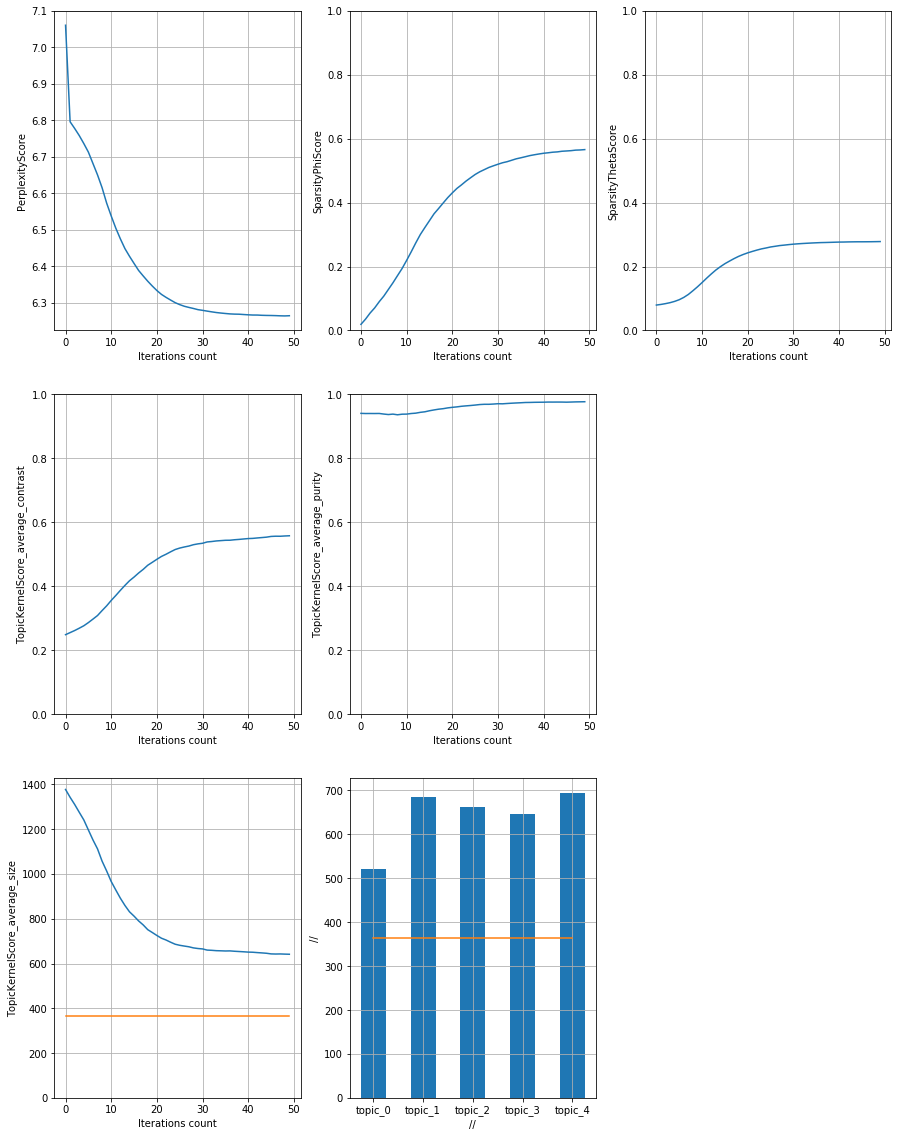

PerplexityScore: 6.265028476715088
SparsityPhiScore: 0.5655854940414429
SparsityThetaScore: 0.27800050377845764

TopicKernelScore_average_contrast: 0.5579336881637573
TopicKernelScore_average_purity: 0.9771021008491516
TopicKernelScore_average_size: 641.4000244140625

TopTokensScore:
topic_0: помнить вспоминать нужно сидеть задавать здесь думать хорошо читать снова 
topic_1: публичный партия выборы вконтакте европейский госдума открытый еспча иностранный ненависть 
topic_2: превышение изолятор тяжкий причинение освобождать правый компенсация зона освобождение исправительный 
topic_3: призыв предприятие бизнесмен министерство министр мошенничество особо миллион чиновник счет 
topic_4: дверь подросток пистолет отец скончаться бить взрыв ударять девочка скорый 


In [91]:
model_print_results(model_artm)

In [29]:
params = {
    'topic_count': 5,
    'num_collection_passes': 50,
    'SparsePhi': {
        'name': 'SparsePhi',
        'tau': -5
    },
    'SparseTheta': {
        'name': 'SparseTheta',
        'tau': -3
    },
}

In [30]:
# Базовая пустая модель
model_artm = new_default_model(params['topic_count'], dictionary)
model_artm.save("news_model_0")

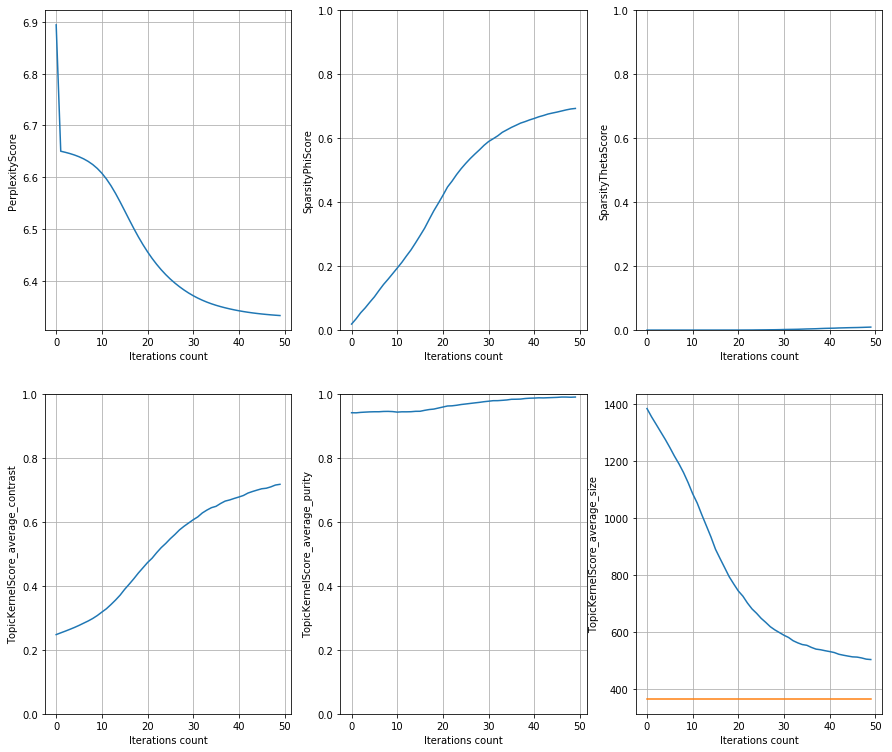

PerplexityScore: 6.332602500915527
SparsityPhiScore: 0.6931281089782715
SparsityThetaScore: 0.009334919042885303

TopicKernelScore_average_contrast: 0.7176509499549866
TopicKernelScore_average_purity: 0.9905760884284973
TopicKernelScore_average_size: 503.20001220703125

TopTokensScore:
topic_0: ['помнить', 'вспоминать', 'нужно', 'поддерживать', 'специалист', 'напоминать', 'задавать', 'разный', 'возможность', 'здесь']
topic_1: ['партия', 'социальный', 'иностранный', 'публичный', 'госдума', 'еспча', 'вконтакте', 'прекращать', 'нарушать', 'поддержка']
topic_2: ['превышение', 'повреждение', 'изолятор', 'оказывать', 'тяжкий', 'умирать', 'правый', 'восемь', 'травма', 'причинение']
topic_3: ['призыв', 'особо', 'предприятие', 'министерство', 'бизнесмен', 'офис', 'мошенничество', 'министр', 'официальный', 'миллион']
topic_4: ['дверь', 'бить', 'подросток', 'увидеть', 'отец', 'пистолет', 'скончаться', 'уезжать', 'взрыв', 'несовершеннолетний']


In [31]:
# Модель 1_1
# Запуск регуляризатора SparsePhi

model_artm = new_default_model(params['topic_count'], dictionary)
model_artm.load("news_model_0")

if params['SparsePhi']['name'] not in list(model_artm.regularizers.data):
    model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name=params['SparsePhi']['name']))
model_artm.regularizers[params['SparsePhi']['name']].tau = params['SparsePhi']['tau']

model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=params['num_collection_passes'])
model_print_results(model_artm)

model_artm.save("news_model_1_1")

# Модель 1_2
# Запуск регуляризатора SparseTheta к уже включенному SparsePhi

#model_artm = new_default_model(params['topic_count'], dictionary)
#model_artm.load("news_model_1_1")

if params['SparsePhi']['name'] not in list(model_artm.regularizers.data):
    model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name=params['SparsePhi']['name']))
model_artm.regularizers[params['SparsePhi']['name']].tau = params['SparsePhi']['tau']
    
if params['SparseTheta']['name'] not in list(model_artm.regularizers.data):
    model_artm.regularizers.add(artm.SmoothSparseThetaRegularizer(name=params['SparseTheta']['name']))
model_artm.regularizers[params['SparseTheta']['name']].tau = params['SparseTheta']['tau']

model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=params['num_collection_passes'])
model_print_results(model_artm)

model_artm.save("news_model_1_2")

In [ ]:
params = {
    'topic_count': 10,
    'num_collection_passes': 50,
    'SparsePhi': {
        'name': 'SparsePhi',
        'tau': -5
    },
    'SparseTheta': {
        'name': 'SparseTheta',
        'tau': -3
    },
}

In [ ]:
# Модель 1_1
# Запуск регуляризатора SparsePhi

model_artm = new_default_model(params['topic_count'], dictionary)
model_artm.load("news_model_0")

if params['SparsePhi']['name'] not in list(model_artm.regularizers.data):
    model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name=params['SparsePhi']['name']))
model_artm.regularizers[params['SparsePhi']['name']].tau = params['SparsePhi']['tau']

model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=params['num_collection_passes'])
model_print_results(model_artm)

model_artm.save("news_model_1_1")

# Модель 1_2
# Запуск регуляризатора SparseTheta к уже включенному SparsePhi

#model_artm = new_default_model(params['topic_count'], dictionary)
#model_artm.load("news_model_1_1")

if params['SparsePhi']['name'] not in list(model_artm.regularizers.data):
    model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name=params['SparsePhi']['name']))
model_artm.regularizers[params['SparsePhi']['name']].tau = params['SparsePhi']['tau']
    
if params['SparseTheta']['name'] not in list(model_artm.regularizers.data):
    model_artm.regularizers.add(artm.SmoothSparseThetaRegularizer(name=params['SparseTheta']['name']))
model_artm.regularizers[params['SparseTheta']['name']].tau = params['SparseTheta']['tau']

model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=params['num_collection_passes'])
model_print_results(model_artm)

model_artm.save("news_model_1_2")

In [ ]:
params = {
    'topic_count': 15,
    'num_collection_passes': 50,
    'SparsePhi': {
        'name': 'SparsePhi',
        'tau': -5
    },
    'SparseTheta': {
        'name': 'SparseTheta',
        'tau': -3
    },
}

In [ ]:
# Модель 1_1
# Запуск регуляризатора SparsePhi

model_artm = new_default_model(params['topic_count'], dictionary)
model_artm.load("news_model_0")

if params['SparsePhi']['name'] not in list(model_artm.regularizers.data):
    model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name=params['SparsePhi']['name']))
model_artm.regularizers[params['SparsePhi']['name']].tau = params['SparsePhi']['tau']

model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=params['num_collection_passes'])
model_print_results(model_artm)

model_artm.save("news_model_1_1")

# Модель 1_2
# Запуск регуляризатора SparseTheta к уже включенному SparsePhi

#model_artm = new_default_model(params['topic_count'], dictionary)
#model_artm.load("news_model_1_1")

if params['SparsePhi']['name'] not in list(model_artm.regularizers.data):
    model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name=params['SparsePhi']['name']))
model_artm.regularizers[params['SparsePhi']['name']].tau = params['SparsePhi']['tau']
    
if params['SparseTheta']['name'] not in list(model_artm.regularizers.data):
    model_artm.regularizers.add(artm.SmoothSparseThetaRegularizer(name=params['SparseTheta']['name']))
model_artm.regularizers[params['SparseTheta']['name']].tau = params['SparseTheta']['tau']

model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=params['num_collection_passes'])
model_print_results(model_artm)

model_artm.save("news_model_1_2")

In [ ]:
params = {
    'topic_count': 20,
    'num_collection_passes': 50,
    'SparsePhi': {
        'name': 'SparsePhi',
        'tau': -5
    },
    'SparseTheta': {
        'name': 'SparseTheta',
        'tau': -3
    },
}

In [ ]:
# Модель 1_1
# Запуск регуляризатора SparsePhi

model_artm = new_default_model(params['topic_count'], dictionary)
model_artm.load("news_model_0")

if params['SparsePhi']['name'] not in list(model_artm.regularizers.data):
    model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name=params['SparsePhi']['name']))
model_artm.regularizers[params['SparsePhi']['name']].tau = params['SparsePhi']['tau']

model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=params['num_collection_passes'])
model_print_results(model_artm)

model_artm.save("news_model_1_1")

# Модель 1_2
# Запуск регуляризатора SparseTheta к уже включенному SparsePhi

#model_artm = new_default_model(params['topic_count'], dictionary)
#model_artm.load("news_model_1_1")

if params['SparsePhi']['name'] not in list(model_artm.regularizers.data):
    model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name=params['SparsePhi']['name']))
model_artm.regularizers[params['SparsePhi']['name']].tau = params['SparsePhi']['tau']
    
if params['SparseTheta']['name'] not in list(model_artm.regularizers.data):
    model_artm.regularizers.add(artm.SmoothSparseThetaRegularizer(name=params['SparseTheta']['name']))
model_artm.regularizers[params['SparseTheta']['name']].tau = params['SparseTheta']['tau']

model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=params['num_collection_passes'])
model_print_results(model_artm)

model_artm.save("news_model_1_2")

In [84]:
help(model_artm.score_tracker['TopTokensScore'])

Help on TopTokensScoreTracker in module artm.score_tracker object:

class TopTokensScoreTracker(BaseScoreTracker)
 |  Method resolution order:
 |      TopTokensScoreTracker
 |      BaseScoreTracker
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, score)
 |      :Properties:
 |      * Note: every field is a list of info about score on all synchronizations.
 |      * num_tokens - number of requested top tokens.
 |      * coherence - each element of list is a dict, key - topic name, value - topic coherence                      counted using top-tokens
 |      * average_coherence - average coherencies of all scored topics.
 |      * tokens - each element of list is a dict, key - topic name, value - list of top-tokens
 |      * weights - each element of list is a dict, key - topic name, value - list of weights of                    corresponding top-tokens (weight of token == p(w|t))
 |      * Note: every field has a version with prefix 'last_', means retrievin

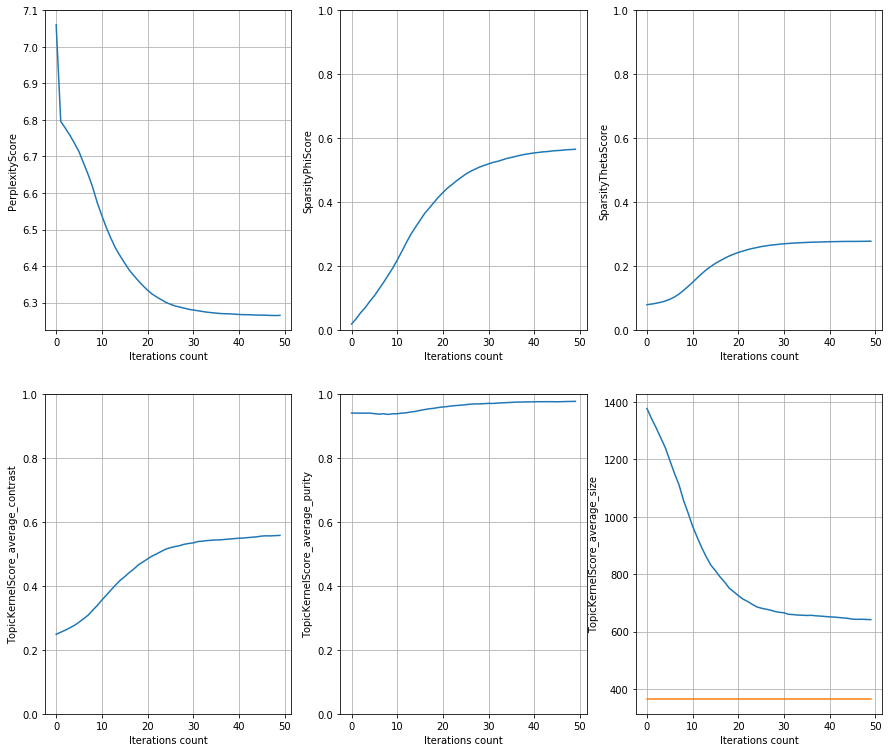

PerplexityScore: 6.265028476715088
SparsityPhiScore: 0.5655854940414429
SparsityThetaScore: 0.27800050377845764

TopicKernelScore_average_contrast: 0.5579336881637573
TopicKernelScore_average_purity: 0.9771021008491516
TopicKernelScore_average_size: 641.4000244140625

TopTokensScore:
topic_0: ['помнить', 'вспоминать', 'нужно', 'сидеть', 'задавать', 'здесь', 'думать', 'хорошо', 'читать', 'снова']
topic_1: ['публичный', 'партия', 'выборы', 'вконтакте', 'европейский', 'госдума', 'открытый', 'еспча', 'иностранный', 'ненависть']
topic_2: ['превышение', 'изолятор', 'тяжкий', 'причинение', 'освобождать', 'правый', 'компенсация', 'зона', 'освобождение', 'исправительный']
topic_3: ['призыв', 'предприятие', 'бизнесмен', 'министерство', 'министр', 'мошенничество', 'особо', 'миллион', 'чиновник', 'счет']
topic_4: ['дверь', 'подросток', 'пистолет', 'отец', 'скончаться', 'бить', 'взрыв', 'ударять', 'девочка', 'скорый']


In [33]:
# Модель 2_1
# Запуск регуляризаторов SparsePhi и SparseTheta одновременно и сначала обучения

model_artm = new_default_model(params['topic_count'], dictionary)
model_artm.load("news_model_0")

if params['SparsePhi']['name'] not in list(model_artm.regularizers.data):
    model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name=params['SparsePhi']['name']))
model_artm.regularizers[params['SparsePhi']['name']].tau = params['SparsePhi']['tau']
    
if params['SparseTheta']['name'] not in list(model_artm.regularizers.data):
    model_artm.regularizers.add(artm.SmoothSparseThetaRegularizer(name=params['SparseTheta']['name']))
model_artm.regularizers[params['SparseTheta']['name']].tau = params['SparseTheta']['tau']

model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=params['num_collection_passes'])
model_print_results(model_artm)

model_artm.save("news_model_2_1")

In [37]:
model_artm.phi_.shape[0]/model_artm.num_topics

363.8

<Container object of 5 artists>

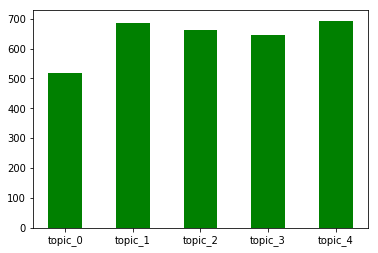

In [36]:
myDictionary = model_artm.score_tracker['TopicKernelScore'].last_size
plt.bar(myDictionary.keys(), myDictionary.values(), 0.5, color='g')

In [15]:
model_artm.score_tracker['TopicKernelScore'].last_size

{'topic_0': 6.0,
 'topic_1': 5.0,
 'topic_10': 6.0,
 'topic_100': 6.0,
 'topic_101': 6.0,
 'topic_102': 7.0,
 'topic_103': 6.0,
 'topic_104': 5.0,
 'topic_105': 5.0,
 'topic_106': 5.0,
 'topic_107': 6.0,
 'topic_108': 7.0,
 'topic_109': 6.0,
 'topic_11': 7.0,
 'topic_110': 5.0,
 'topic_111': 5.0,
 'topic_112': 7.0,
 'topic_113': 7.0,
 'topic_114': 6.0,
 'topic_115': 4.0,
 'topic_116': 5.0,
 'topic_117': 6.0,
 'topic_118': 8.0,
 'topic_119': 5.0,
 'topic_12': 5.0,
 'topic_120': 6.0,
 'topic_121': 5.0,
 'topic_122': 9.0,
 'topic_123': 4.0,
 'topic_124': 8.0,
 'topic_125': 6.0,
 'topic_126': 8.0,
 'topic_127': 5.0,
 'topic_128': 7.0,
 'topic_129': 7.0,
 'topic_13': 8.0,
 'topic_130': 5.0,
 'topic_131': 6.0,
 'topic_132': 8.0,
 'topic_133': 6.0,
 'topic_134': 8.0,
 'topic_135': 8.0,
 'topic_136': 6.0,
 'topic_137': 6.0,
 'topic_138': 7.0,
 'topic_139': 5.0,
 'topic_14': 7.0,
 'topic_140': 9.0,
 'topic_141': 6.0,
 'topic_142': 6.0,
 'topic_143': 5.0,
 'topic_144': 6.0,
 'topic_145': 6.0,
 '

In [14]:
help(model_artm.score_tracker['TopicKernelScore'])

Help on TopicKernelScoreTracker in module artm.score_tracker object:

class TopicKernelScoreTracker(BaseScoreTracker)
 |  Method resolution order:
 |      TopicKernelScoreTracker
 |      BaseScoreTracker
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, score)
 |      :Properties:
 |      * Note: every field is a list of info about score on all synchronizations.
 |      * tokens - each element of list is a dict, key - topic name, value - list of kernel tokens
 |      * size - each element of list is a dict, key - topic name, value - kernel size
 |      * contrast - each element of list is a dict, key - topic name, value - kernel contrast
 |      * purity - each element of list is a dict, key - topic name, value - kernel purity
 |      * coherence - each element of list is a dict, key - topic name, value - topic coherence                      counted using kernel tokens
 |      * average_size - average kernel size of all scored topics.
 |      * average_cont

In [131]:
# Установка регуляризаторов
model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi'))
#model_artm.regularizers.add(artm.SmoothSparseThetaRegularizer(name='SparseTheta'))
#model_artm.regularizers.add(artm.DecorrelatorPhiRegularizer(name='DecorrelatorPhi'))


#model_artm.regularizers.add(artm.TopicSelectionThetaRegularizer(name='TopicSelectionTheta', tau=0.1))

In [132]:
# Правка регуляризаторов
model_artm.regularizers['SparsePhi'].tau = -3
#model_artm.regularizers['SparseTheta'].tau = -2
#model_artm.regularizers['DecorrelatorPhi'].tau = 2.5e+5

Полезные идеи по нулевым значениям:
https://github.com/bigartm/bigartm/issues/664